<a href="https://colab.research.google.com/github/jiho/ML4Oceans/blob/main/Day_5-PhysicsInformedAI/Lab2_PINNs_ML4Ocean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI-informed physics, lab 1: PINNs**
## *ML4Oceans Summer School 2022*
##### Redouane Lguensat (IPSL/IRD) (https://redouanelg.github.io)

References:
* Raissi et al. 2017 https://arxiv.org/abs/1711.10561
* https://cloud4scieng.org/2020/06/10/notes-on-deep-learning-and-differential-equations/
* https://maziarraissi.github.io/PINNs/ 
* https://github.com/erfanhamdi/pinn-torch/tree/main/Burgers_Equation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# PINN for solving Burgers equation 

Burgers Equation (https://en.wikipedia.org/wiki/Burgers%27_equation)

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0,
$$

where $x \in [-1, 1]$ and time $t \in [0, 1]$.

The parameter $\nu$ is 0.01/pi (viscus Burgers equation case).

**Boundary conditions:**

the upper and lower boundary values are taken to be 0, i.e., $u(t,-1) = u(t,1)= 0$.  

 When t=0, the starting condition is taken to be $u(0,x) = -sin(pi*x)$.


**Goal**

In this notebook we will use the PINN (Physical Informed Neural Network) idea from Raissi et al. (2017). The goal is to train a neural network that satisfies the differential equation and the boundary conditions.

**Remark**

In the general case we use also some samples from the solution $u$ for training (the data fidelity term of the loss function). But here we will see that the equation loss and the boundary loss are sufficient. The reason is that the form of the Burgers equation we are considering has a unique solution. So please keep in mind that this is not always the case.

# Data preparation

Let us start by creating a training dataset by sampling from random positions in the boundaries. Remember that the inputs for the neural nets are $x$ and $t$ and the output is $u(x,t)$

In [3]:
np.random.seed(2022)

nu = 0.01 / np.pi # the $\nu$ constat in the Burgers equation
N_u = 400   # number of training samples from the boundaries
N_f = 2000  # number of collocation points

x_upper = np.ones((N_u//4, 1), dtype=float)
x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
t_zero = np.zeros((N_u//2, 1), dtype=float)

t_upper = np.random.rand(N_u//4, 1)
t_lower = np.random.rand(N_u//4, 1)
x_zero = (-1) + np.random.rand(N_u//2, 1) * (1 - (-1))

# stack uppers, lowers and zeros:
X_upper = np.hstack( (x_upper, t_upper) )
X_lower = np.hstack( (x_lower, t_lower) )
X_zero = np.hstack( (x_zero, t_zero) )

# each one of these three arrays haS 2 columns, 
# now we stack them vertically, the resulting array will also have 2 
# columns and 100 rows:
X_u_train = np.vstack( (X_upper, X_lower, X_zero) )

# shuffle X_u_train:
index = np.arange(0, N_u)
np.random.shuffle(index)
X_u_train = X_u_train[index, :]

# PINN functions

Create a Multilayer perceptron with Tanh activation function, that has 4 hidden layers with 20 neurons each. Write also a function that initialize the weights of the MLP using a Xavier_Normal initialization and initialize the biases with zero.

In [4]:
## ANSWER
class PINNBurgers(nn.Module):
    def __init__(self,):
        super(PINNBurgers, self).__init__()
        # Input layer
        self.inp = nn.Linear(2, 20)
        # Hidden layers
        self.layers = nn.ModuleList(
            [nn.Linear(20, 20) for i in range(3)]
        )
        # Output layer
        self.outp = nn.Linear(20, 1)
        # Activation function
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.inp(x)
        x = self.act(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.outp(x)
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)

Now that we have created our neural net that acts as $u(x,t)$, time to create the PINN loss function. Reminder that the PINN loss function here will consist of:
* the boundary loss which is just a classical MSE loss between the outputs of the neural nets and the training boundary samples 
* the differential equation loss that satisfies
$$
\mathcal{F(x,t)} = \frac{\partial u(x,t)}{\partial t} + u(x,t)\frac{\partial u(x,t)}{\partial x} - \nu \frac{\partial^2 u(x,t)}{\partial x^2} = 0,
$$ for this one you will need to calculate derivatives, we already provide the torch function that does that

In [5]:
def gradient(func, x, order = 1):
    for i in range(order):
        func = torch.autograd.grad(func, x, grad_outputs = torch.ones_like(func), create_graph=True, retain_graph=True)[0]
    return func

Now write the function $\mathcal{F}$ and also the complete PINN loss

In [6]:
## ANSWER

def f(model, x, t):
    u = model(torch.stack((x, t), axis = 1))
    u_t = gradient(u, t, order=1)
    u_x = gradient(u, x, order=1)
    u_xx = gradient(u, x, order=2)
    return u_t + u.T * u_x - nu * u_xx

def PINNloss(model, x, t, x_b, t_b, y_u):
    mseloss = torch.nn.MSELoss()
    function_loss = mseloss(f(model, x, t), torch.zeros(1)) 
    boundary_loss = mseloss(model(torch.stack((x_b, t_b), axis = 1)), y_u)
    return function_loss + boundary_loss

The next provided functions are used to train the PINN model, we will use the L-BFGS optimizer, a second-order optimization algorithm, which converges quicker for this problem than ADAM, but has higher computational and memory requirements.

In [7]:
h_lbfgs = []

def train(model, X_u_train, X_f_train, u_train):
    optimizer = torch.optim.LBFGS(model.parameters(),lr=1,max_iter=100)
    for iter in range(0,50):
      def closure():
          x_u = X_u_train[:, 0]
          t_u = X_u_train[:, 1]
          x_f = X_f_train[:, 0]
          t_f = X_f_train[:, 1]
          y_u = u_train
          if torch.is_grad_enabled():
            optimizer.zero_grad()
          loss = PINNloss(model, x_f, t_f, x_u, t_u, y_u)
          if loss.requires_grad:
            loss.backward()
          print(f" iteration: {iter}  loss: {loss.item()}")
          h_lbfgs.append(loss.item())
          return loss
      optimizer.step(closure)

In [8]:
# make X_f_train:
from random import uniform
np.random.seed(2022)

X_f_train = np.zeros((N_f, 2), dtype=float)
for row in range(N_f):
    x = uniform(-1, 1)  # x range
    t = uniform( 0, 1)  # t range

    X_f_train[row, 0] = x 
    X_f_train[row, 1] = t

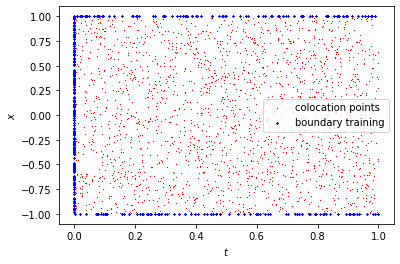

In [9]:
plt.scatter(X_f_train[:,1], X_f_train[:,0], s=0.1, color='r', marker='x', label='colocation points')
plt.scatter(X_u_train[:,1], X_u_train[:,0], s=2, color='b', marker='x', label='boundary training')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.legend()

In [10]:
# add the boundary points to the collocation points:
X_f_train = np.vstack( (X_f_train, X_u_train) )

In [11]:
# make u_train
u_upper =  np.zeros((N_u//4, 1), dtype=float)
u_lower =  np.zeros((N_u//4, 1), dtype=float) 
u_zero = -np.sin(np.pi * x_zero)  

# stack them in the same order as X_u_train was stacked:
u_train = np.vstack( (u_upper, u_lower, u_zero) )

# match indices with X_u_train
u_train = u_train[index, :]

In [12]:
X_u_train = torch.from_numpy(X_u_train).requires_grad_(True).float()
X_f_train = torch.from_numpy(X_f_train).requires_grad_(True).float()
u_train = torch.from_numpy(u_train).requires_grad_(True).float()

In [13]:
# Model instantiation
model = PINNBurgers()
model.apply(init_weights)

PINNBurgers(
  (inp): Linear(in_features=2, out_features=20, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (outp): Linear(in_features=20, out_features=1, bias=True)
  (act): Tanh()
)

In [ ]:
# Training
iter = 0
model.train()
train(model, X_u_train, X_f_train, u_train)

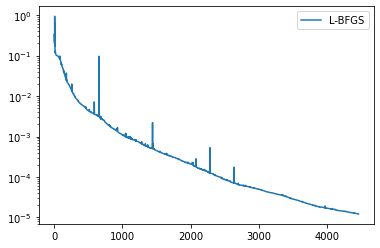

In [15]:
plt.semilogy(h_lbfgs, label='L-BFGS')
plt.legend()

# Plot PINN solution

In [16]:
x_size = 400
t_size = 200

x = torch.linspace(-1, 1, 400)
t = torch.linspace( 0, 1, 200)
X, T = torch.meshgrid(x, t)
PINN_input = torch.cat((X.reshape(-1, 1), T.reshape(-1, 1)), 1)

# PINN solution
model.eval()
sol = model(PINN_input).reshape(x_size, t_size)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


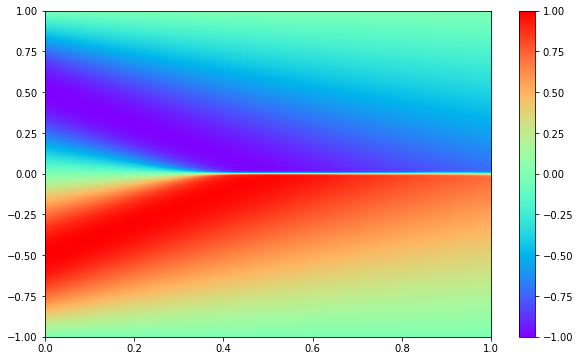

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

h = ax.imshow(sol.detach().numpy(), cmap='rainbow', vmin=-1, vmax=1,
              extent=[t.numpy().min(), t.numpy().max(), x.numpy().min(), x.numpy().max()],
              origin='lower', aspect='auto')
cbar = fig.colorbar(h)
plt.show()

Visualize the shock wave

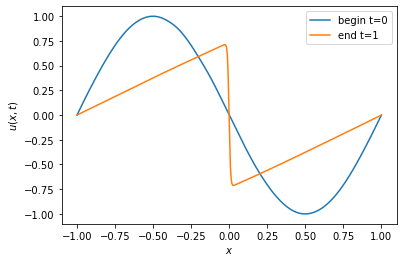

In [18]:
plt.plot(x.numpy(), sol.detach().numpy()[:,0], label='begin t=0')
plt.plot(x.numpy(), sol.detach().numpy()[:,-1], label='end t=1')
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x,t)$')
plt.legend()